<a href="https://colab.research.google.com/github/natalialnb/Mini-Case-PySpark/blob/main/Untitled6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="#cd7f32"> **Mini Case PySpark** </font>
**Jump Start**

### O Que é Particionamento?

Particionamento é a forma como o PySpark divide um grande conjunto de dados em partes menores, chamadas de "partições". Cada partição é um pedaço de dados que pode ser processado de forma independente e paralela. A ideia dessa divisão é distribuir a carga de trabalho, para acelerar o processamento e tornar a análise de big data mais eficiente.

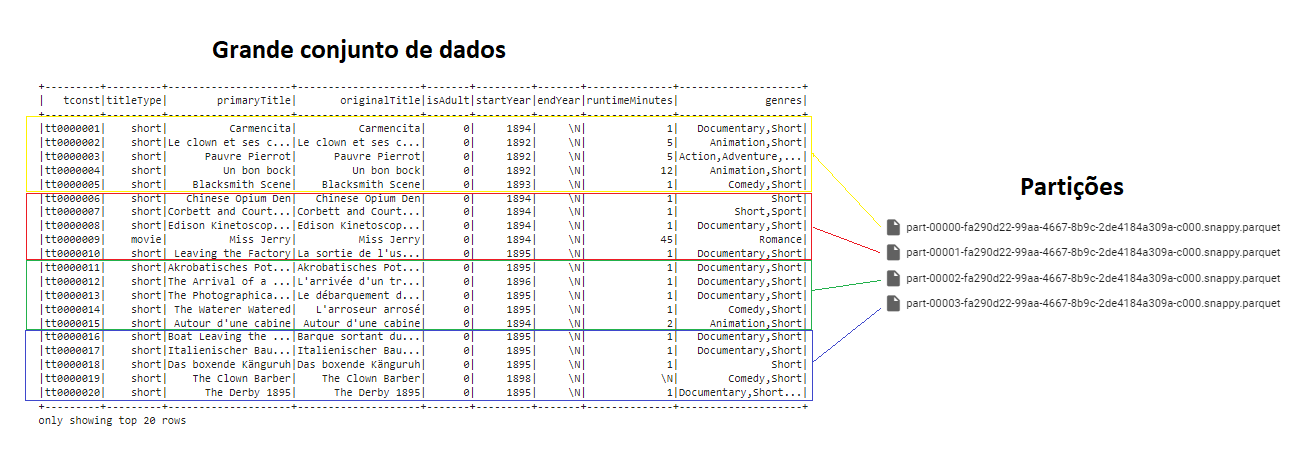

### Como o Particionamento Funciona no PySpark

1. **Partições de RDD**: No PySpark, os dados são representados por RDDs (Resilient Distributed Datasets). Um RDD é dividido em várias partições, que são processadas em paralelo. O número de partições pode ser ajustado para otimizar a performance.

2. **DataFrames e Datasets**: Para DataFrames e Datasets, o particionamento é um pouco mais abstrato, mas o princípio é o mesmo. Dados são divididos em partições para serem processados em paralelo.

### Como podemos particionar o conjunto de dados:

#### **Número(quantidade de divisões) e Colunas**



In [7]:
!pip install pyspark

In [8]:
# Importando bibliotecas e os dados

In [32]:
from pyspark.sql import SparkSession
import time


# Inicializando uma Spark Session
spark = SparkSession.builder.appName("TitleBasicsExample").getOrCreate()

# Lendo o arquivo TSV comprimido
df = spark.read.csv("title.basics.tsv.gz", sep='\t', header=True, inferSchema=True)

# Exibindo o esquema do DataFrame
df.printSchema()

# Exibindo as primeiras 5 linhas do DataFrame
df.show()

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,

In [10]:
total_count = df.count()

print(f"Número total de registros: {total_count}")

Número total de registros: 8722919


##### **10 partições**



Você pode definir o número de partições ao criar um RDD, usar a função `repartition()` ou `coalesce()` em DataFrames. O `repartition()` aumenta ou diminui o número de partições e pode causar um shuffle (redistribuição dos dados), enquanto o `coalesce()` é mais eficiente para reduzir o número de partições sem shuffle.

   ```python
   # Exemplo de reparticionamento
   df = df.repartition(10)
   ```

In [12]:
df_particionado_num = df.repartition(10)

# Exibindo o número de partições
print("Número de partições:", df_particionado_num.rdd.getNumPartitions())

Número de partições: 10


In [13]:
# Salvando o DataFrame particionado em formato Parquet
df_particionado_num.write.parquet("output/particionado_num")

In [15]:
def count_in_partition(index, iterator):
    count = sum(1 for _ in iterator)
    yield (index, count)

# Aplicando a função para contar linhas em cada partição
partition_counts = df_particionado_num.rdd.mapPartitionsWithIndex(count_in_partition).collect()

# Exibindo o número de linhas em cada partição
for partition, count in partition_counts:
    print(f"Partição {partition}: {count} linhas")

Partição 0: 872292 linhas
Partição 1: 872292 linhas
Partição 2: 872292 linhas
Partição 3: 872292 linhas
Partição 4: 872292 linhas
Partição 5: 872292 linhas
Partição 6: 872292 linhas
Partição 7: 872292 linhas
Partição 8: 872291 linhas
Partição 9: 872292 linhas


**O que é mais performático?**

In [49]:
# Marcar o início do tempo
start_time1 = time.time()

# Realizar o groupBy e contar os registros
df_grouped_df_int = df.groupBy("titleType").count()

# Coletar os resultados para visualizar (isto pode demorar dependendo do tamanho dos dados)
result_int = df_grouped_df_int.collect()

# Marcar o fim do tempo
end_time1 = time.time()

# Exibir o tempo decorrido
elapsed_time1 = end_time1 - start_time1
print(f"Tempo de processamento - DF Inteiro: {elapsed_time1:.2f} segundos")

# Exibir os resultados do groupBy
df_grouped_df_int.show()

Tempo de processamento - DF Inteiro: 26.94 segundos
+------------+-------+
|   titleType|  count|
+------------+-------+
|    tvSeries| 267274|
|tvMiniSeries|  55821|
|     tvMovie| 148136|
|     tvPilot|      1|
|   tvEpisode|8396170|
|       movie| 687760|
|   tvSpecial|  48520|
|       video| 295724|
|   videoGame|  39407|
|     tvShort|  10365|
|       short|1007976|
+------------+-------+



In [50]:
# Marcar o início do tempo
start_time = time.time()

# Realizar o groupBy e contar os registros
df_grouped = df_particionado_num.groupBy("titleType").count()

# Coletar os resultados para visualizar (isto pode demorar dependendo do tamanho dos dados)
result = df_grouped.collect()

# Marcar o fim do tempo
end_time = time.time()

# Exibir o tempo decorrido
elapsed_time = end_time - start_time
print(f"Tempo de processamento- DF Particionado: {elapsed_time:.2f} segundos")

# Exibir os resultados do groupBy
df_grouped.show()

Tempo de processamento- DF Particionado: 33.26 segundos
+------------+-------+
|   titleType|  count|
+------------+-------+
|    tvSeries| 215743|
|tvMiniSeries|  43668|
|     tvMovie| 123422|
|   tvEpisode|6642733|
|       movie| 578512|
|   tvSpecial|  42668|
|       video| 242366|
|   videoGame|  31505|
|     tvShort|   6931|
|       short| 795370|
|     tvPilot|      1|
+------------+-------+



#### **Coluna:**

 Ao usar operações como `groupBy` ou `join`, você pode particionar os dados com base em uma coluna específica. Isso pode melhorar a eficiência do processamento, especialmente se os dados são frequentemente agrupados ou filtrados com base nessa coluna.

   ```python
   # Exemplo de particionamento por coluna
   df = df.repartition('column_name')
   ````

In [18]:
# Particionando o DataFrame com base na coluna titleType
df_particionado_col = df.repartition("titleType")

# Salvando o DataFrame particionado em formato Parquet
df_particionado_col.write.partitionBy("titleType").parquet("output/particionado_col")

In [38]:
# Particionando o DataFrame com base na coluna titleType
df_particionado_col = df.repartition("titleType")

# Verificando o número de partições
print("Número de partições:", df_particionado_col.rdd.getNumPartitions())

# Contando o número de registros em cada partição
df_particionado_col.groupBy("titleType").count().show()

Número de partições: 5
+------------+-------+
|   titleType|  count|
+------------+-------+
|    tvSeries| 267274|
|tvMiniSeries|  55821|
|     tvMovie| 148136|
|     tvPilot|      1|
|   tvEpisode|8396170|
|       movie| 687760|
|   tvSpecial|  48520|
|       video| 295724|
|   videoGame|  39407|
|     tvShort|  10365|
|       short|1007976|
+------------+-------+



**O que é mais performático?**

In [51]:
start_time = time.time()
df_filtered = df.filter(df.titleType == 'tvEpisode')
start_time = time.time()

# Realizar o groupBy por startYear e contar os registros
df_grouped = df_filtered.groupBy("startYear").count()

# Coletar os resultados para visualizar (isto pode demorar dependendo do tamanho dos dados)
result = df_grouped.collect()

# Marcar o fim do tempo
end_time = time.time()

# Exibir o tempo decorrido
elapsed_time = end_time - start_time
print(f"Tempo de processamento - Df Inteiro: {elapsed_time:.2f} segundos")

# Exibir os resultados do groupBy
df_grouped.show()


Tempo de processamento - Df Inteiro: 27.03 segundos
+---------+------+
|startYear| count|
+---------+------+
|     1953|  7123|
|     1957| 11776|
|     1987| 37473|
|     1956|  9770|
|     2016|315899|
|     1936|    63|
|     2012|246891|
|     2020|326659|
|     1958| 13105|
|     1943|    26|
|     1972| 29023|
|     1931|    14|
|     2026|   102|
|     1988| 36617|
|     1938|   230|
|     2019|341928|
|     2017|336201|
|     1932|    10|
|     1977| 29546|
|     1971| 29537|
+---------+------+
only showing top 20 rows



In [52]:
start_load_time = time.time()

# Carregar o DataFrame particionado
df_filtered = spark.read.parquet("/content/output/particionado_col/titleType=tvEpisode")


# Marcar o fim do tempo de carregamento
end_load_time = time.time()

# Tempo de carregamento
load_time = end_load_time - start_load_time

# Marcar o início do tempo de processamento
start_process_time = time.time()

# Agrupar os dados pelo ano de início e contar
df_grouped = df_filtered.groupBy("startYear").count()

# Coletar os resultados para visualizar (isto pode demorar dependendo do tamanho dos dados)
result = df_grouped.collect()

# Marcar o fim do tempo de processamento
end_process_time = time.time()

# Tempo de processamento
process_time = end_process_time - start_process_time

# Exibir os tempos decorrido
print(f"Tempo de processamento para carregar o DF particionado: {load_time:.2f} segundos")
print(f"Tempo de processamento para processar o DF particionado: {process_time:.2f} segundos")

# Exibir os resultados do groupBy
df_grouped.show()

Tempo de processamento para carregar o DF particionado: 0.09 segundos
Tempo de processamento para processar o DF particionado: 1.04 segundos
+---------+------+
|startYear| count|
+---------+------+
|     1953|  6512|
|     1957| 10186|
|     1987| 27817|
|     1956|  8511|
|     2016| 99645|
|     1936|    46|
|     2012|201333|
|     2020|323994|
|     1958| 11140|
|     1943|    25|
|     1972| 19811|
|     1931|    14|
|     2026|    94|
|     1988| 26860|
|     1938|    57|
|     2019|301583|
|     2017|113702|
|     1932|     3|
|     1977| 21853|
|     2014|212374|
+---------+------+
only showing top 20 rows




### Impacto na Performance

1. **Redução de Shuffle**: O *particionamento adequado* pode reduzir a quantidade de shuffle necessário. O shuffle ocorre quando os dados precisam ser redistribuídos entre diferentes partições e pode ser um processo caro em termos de tempo e recursos.

2. **Balanceamento de Carga**: Se as partições forem muito grandes ou muito pequenas, isso pode causar um balanceamento desigual da carga de trabalho entre os nós do cluster. O particionamento adequado ajuda a garantir que cada nó esteja trabalhando com uma quantidade equilibrada de dados.

3. **Melhoria da Localidade dos Dados**: Particionamento pode melhorar a localidade dos dados, ou seja, *dados que são frequentemente acessados juntos são colocados na mesma partição*. Isso reduz o tempo de acesso e melhora a eficiência.

4. **Performance de Operações**: Operações como `join`, `groupBy`, e `aggregate` podem ser muito mais eficientes quando o *particionamento é feito com base nas colunas relevantes*. Isso minimiza a quantidade de dados que precisam ser movidos entre partições.

5. **Efeito da Persistência**: Se você estiver persistindo dados em memória (`cache()` ou `persist()`), o particionamento adequado também pode impactar a eficiência do armazenamento e recuperação desses dados.


### Boas Práticas para Particionamento

1. **Ajustar o Número de Partições**: O número ideal de partições depende do tamanho dos dados e dos recursos disponíveis no cluster. Testar e ajustar o número de partições pode melhorar a performance.

2. **Evitar Partições Pequenas**: Partições muito pequenas podem resultar em overhead excessivo. O ideal é ter um número razoável de partições, onde cada uma contém uma quantidade significativa de dados.

3. **Escolher Colunas Adequadas para Particionamento**: Ao particionar com base em uma coluna, escolha uma coluna que distribua os dados de maneira uniforme e que seja frequentemente usada em operações de agrupamento ou junção.

4. **Monitorar e Ajustar**: Utilize ferramentas de monitoramento do Spark para analisar a performance e ajustar o particionamento conforme necessário.


### Conclusão

O particionamento é uma ferramenta poderosa no PySpark para otimizar o processamento de grandes volumes de dados. Um particionamento eficaz pode:
- reduzir o tempo de processamento;
- melhorar o balanceamento de carga;
- minimizar o custo de operações de shuffle;
- maximizar a eficiência das suas análises em big data.
